In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats
from scipy.stats import norm
from random import choices

import requests

import plotly.graph_objects as go

from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

In [2]:
path = "NBA_2004_2023_Shots.csv"

In [3]:
data_shots = pd.read_csv(path)
#data_shots2 = pd.read_csv(path) #  The next steps will require the original dataset

In [4]:
# This ensures that when printing the Dataframe, all of the columns will be displayed
pd.set_option('display.max_columns', None)

In [5]:
# Condition for dropping '2PT Field Goal' with distance > 28
condition_2pt = (data_shots['SHOT_TYPE'] == '2PT Field Goal') & (data_shots['SHOT_DISTANCE'] > 28)
# Condition for dropping '3PT Field Goal' with distance < 22
condition_3pt = (data_shots['SHOT_TYPE'] == '3PT Field Goal') & (data_shots['SHOT_DISTANCE'] < 22)

# Combine conditions
condition_to_drop = condition_2pt | condition_3pt

# Drop rows matching the condition
data_shots = data_shots[~condition_to_drop]

In [6]:
# Create a mask for shots made
shots_made_mask = data_shots['SHOT_MADE']

# Initialize POINTS column with 0
data_shots['POINTS'] = 0

# Assign points based on the shot type for shots made
data_shots.loc[shots_made_mask & (data_shots['SHOT_TYPE'] == '2PT Field Goal'), 'POINTS'] = 2
data_shots.loc[shots_made_mask & (data_shots['SHOT_TYPE'] == '3PT Field Goal'), 'POINTS'] = 3

In [7]:
# Define categories for shots
categories = {
    'Layups': [
        'Layup Shot', 'Finger Roll Layup Shot', 'Floating Layup Shot', 'Reverse Layup Shot',
        'Driving Layup Shot', 'Cutting Layup Shot', 'Putback Layup Shot', 'Running Layup Shot',
        'Running Finger Roll Layup Shot', 'Running Reverse Layup Shot', 'Finger Roll Shot', 'Driving Finger Roll Layup Shot'
        'Driving Reverse Layup Shot', 'Cutting Finger Roll Layup Shot', 'Running Alley Oop Layup Shot', 'Alley Oop Layup shot',
        'Driving Finger Roll Shot', 'Turnaround Finger Roll Shot', 'Running Finger Roll Shot', 'Driving Finger Roll Layup Shot',
        'Driving Reverse Layup Shot', 'Tip Layup Shot'
    ],
    'Dunks': [
        'Dunk Shot', 'Alley Oop Dunk Shot', 'Cutting Dunk Shot', 'Driving Dunk Shot', 'Reverse Dunk Shot',
        'Putback Dunk Shot', 'Running Dunk Shot', 'Tip Dunk Shot', 'Slam Dunk Shot', 'Running Alley Oop Dunk Shot',
        'Driving Reverse Dunk Shot', 'Running Reverse Dunk Shot', 'Putback Slam Dunk Shot', 'Driving Slam Dunk Shot',
        'Reverse Slam Dunk Shot', 'Running Slam Dunk Shot', 'Putback Reverse Dunk Shot', 'Follow Up Dunk Shot',
        'Tip Dunk Shot'
    ],
    'Jump Shots': [
        'Jump Shot', 'Pullup Jump Shot', 'Fadeaway Jump Shot', 'Running Jump Shot', 'Jump Bank Shot',
        'Step Back Jump Shot', 'Turnaround Jump Shot', 'Floating Jump Shot', 'Turnaround Fadeaway Shot',
        'Running Pull-Up Jump Shot', 'Driving Floating Jump Shot', 'Driving Jump shot'
    ],
    'Hook Shots': [
        'Hook Shot', 'Driving Hook Shot', 'Turnaround Hook Shot', 'Turnaround Bank Hook Shot',
        'Hook Bank Shot', 'Running Hook Shot', 'Jump Hook Shot', 'Running Bank Hook Shot',
        'Jump Bank Hook Shot'
    ],
    'Bank Shots': [
        'Jump Bank Shot', 'Fadeaway Bank Shot', 'Turnaround Bank Shot',
        'Driving Bank Hook Shot', 'Step Back Bank Jump Shot', 'Turnaround Fadeaway Bank Jump Shot', 'Driving Floating Bank Jump Shot',
        'Driving Bank shot', 'Pullup Bank shot', 'Running Bank shot'
    ],
    'Tip-ins': [
        'Tip Shot', 'Running Tip Shot'
    ],
    'No_Shot' : [
        'No Shot'
    ]

}

# Function to categorize the shots
def categorize(categories, action_type):
    action_type = action_type.lower().strip()
    for category, types in categories.items():
        if any(action_type == t.lower().strip() for t in types):
            return category
    return 'other'

# Apply categorization
data_shots['SHOT_CATEGORY'] = data_shots['ACTION_TYPE'].apply(lambda x: categorize(categories, x))
data_shots2 = data_shots.copy()

In [8]:
# Function for convert the feet in meters
def feet_to_m(x):
  out = round(x*0.3048, 2)
  return out

data_shots['LOC_X'] = data_shots['LOC_X'].apply(lambda x: feet_to_m(x))
data_shots['LOC_Y'] = data_shots['LOC_Y'].apply(lambda x: feet_to_m(x))

In [9]:
# Calculate angle from center for each shot
data_shots['ANGLE_FROM_CENTER'] = np.arctan2(data_shots['LOC_Y'], data_shots['LOC_X'])

# Adjust angles for shots in the left half (x < 0)
left_half_mask = data_shots['LOC_X'] < 0
data_shots.loc[left_half_mask, 'ANGLE_FROM_CENTER'] += np.pi

# Convert angles to degrees if needed
data_shots['ANGLE_FROM_CENTER_DEGREES'] = np.degrees(data_shots['ANGLE_FROM_CENTER'])

In [10]:
data_shots

SEASON_1 SEASON_2     TEAM_ID           TEAM_NAME  PLAYER_ID  \
0            2023  2022-23  1610612764  Washington Wizards     203078   
1            2023  2022-23  1610612764  Washington Wizards     204001   
2            2023  2022-23  1610612764  Washington Wizards    1628420   
3            2023  2022-23  1610612764  Washington Wizards     204001   
4            2023  2022-23  1610612764  Washington Wizards    1630166   
...           ...      ...         ...                 ...        ...   
4012556      2004  2003-04  1610612755  Philadelphia 76ers       2422   
4012557      2004  2003-04  1610612759   San Antonio Spurs       1938   
4012558      2004  2003-04  1610612747  Los Angeles Lakers        406   
4012559      2004  2003-04  1610612756        Phoenix Suns       2063   
4012560      2004  2003-04  1610612748          Miami Heat       2548   

                PLAYER_NAME POSITION_GROUP POSITION   GAME_DATE   GAME_ID  \
0              Bradley Beal              G       SG  10-19-2022  22200004   
1        Kristaps Porzingis              C        C  10-19-2022  22200004   
2              Monte Morris              G       PG  10-19-2022  22200004   
3        Kristaps Porzingis              C        C  10-19-2022  22200004   
4               Deni Avdija              F       SF  10-19-2022  22200004   
...                     ...            ...      ...         ...       ...   
4012556        John Salmons              G       SG  10-28-2003  20300001   
4012557       Manu Ginobili              G       SG  10-28-2003  20300002   
4012558    Shaquille O'Neal              C        C  10-28-2003  20300003   
4012559        Jake Voskuhl              C        C  10-28-2003  20300002   
4012560         Dwyane Wade              G       PG  10-28-2003  20300001   

        HOME_TEAM AWAY_TEAM   EVENT_TYPE  SHOT_MADE  \
0             IND       WAS    Made Shot       True   
1             IND       WAS  Missed Shot      False   
2             IND       WAS    Made Shot       True   
3             IND       WAS    Made Shot       True   
4             IND       WAS    Made Shot       True   
...           ...       ...          ...        ...   
4012556       PHI       MIA    Made Shot       True   
4012557       SAS       PHX  Missed Shot      False   
4012558       LAL       DAL  Missed Shot      False   
4012559       SAS       PHX  Missed Shot      False   
4012560       PHI       MIA  Missed Shot      False   

                            ACTION_TYPE       SHOT_TYPE  \
0                             Jump Shot  3PT Field Goal   
1                   Step Back Jump shot  3PT Field Goal   
2        Running Finger Roll Layup Shot  2PT Field Goal   
3                     Cutting Dunk Shot  2PT Field Goal   
4                     Cutting Dunk Shot  2PT Field Goal   
...                                 ...             ...   
4012556                       Jump Shot  3PT Field Goal   
4012557                       Jump Shot  3PT Field Goal   
4012558                       Jump Shot  2PT Field Goal   
4012559                      Layup Shot  2PT Field Goal   
4012560                      Layup Shot  2PT Field Goal   

                    BASIC_ZONE         ZONE_NAME ZONE_ABB       ZONE_RANGE  \
0                Left Corner 3         Left Side        L          24+ ft.   
1            Above the Break 3            Center        C          24+ ft.   
2              Restricted Area            Center        C  Less Than 8 ft.   
3              Restricted Area            Center        C  Less Than 8 ft.   
4              Restricted Area            Center        C  Less Than 8 ft.   
...                        ...               ...      ...              ...   
4012556          Left Corner 3         Left Side        L          24+ ft.   
4012557      Above the Break 3  Left Side Center       LC          24+ ft.   
4012558  In The Paint (Non-RA)            Center        C  Less Than 8 ft.   
4012559        Restricted Area            Center        C

In [11]:
# Select the season to analyse
season_1 = data_shots[data_shots["SEASON_1"] == (2006)].copy()
season_2 = data_shots[data_shots["SEASON_1"] == (2006)].copy()

**PLOTTING**

In [12]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False, interval=20):
    if ax is None:
        ax = plt.gca()

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                                color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    for element in court_elements:
        ax.add_patch(element)


    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-250, 250)
    ax.set_ylim(-47.5, 422.5)

    return ax

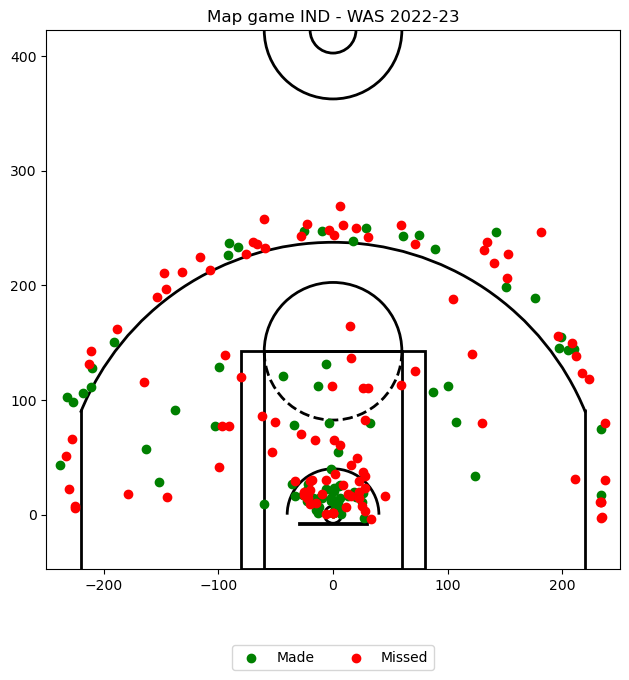

In [13]:
shots = pd.DataFrame()

game_id = 22200004

# Retrive the shots of the right match
shots = data_shots[(data_shots['GAME_ID']) == (game_id)]

# Separate the shots made from the shots failed
made_shots = shots[shots['SHOT_MADE'] == True]
missed_shots = shots[shots['SHOT_MADE'] == False]

# Take the right things for the title of the plot
team_home = (shots['HOME_TEAM']).iloc[0]
team_away = (shots['AWAY_TEAM']).iloc[0]
team_season = (shots['SEASON_2']).iloc[0]

# Setting the parameters for the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Draw the lines field
draw_court(ax)

# Draw the made (green) and the failed (red)
ax.scatter((made_shots['LOC_X']/0.3048)*10, (made_shots['LOC_Y']/0.3048)*9.4-47.5, color='green', label='Made', zorder=2)
ax.scatter((missed_shots['LOC_X']/0.3048)*10, (missed_shots['LOC_Y']/0.3048)*9.4-47.5, color='red', label='Missed', zorder=2)

# Title of the plot
ax.set_title(f"Map game {team_home} - {team_away} {team_season}")
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

# Save the figure and show it
plt.savefig("Player_Shot_Chart.png", dpi=300, bbox_inches='tight')
plt.show()

DATA VISUALIZATION


__________________________________________________________________________________________



**% success rate of shots from every BASIC_ZONE**

In [14]:
# Put back the loc_x and y in feet (for technical reasons)
season_1['LOC_X_rounded'] = season_1['LOC_X'].round(decimals=1) / 0.3048
season_1['LOC_Y_rounded'] = season_1['LOC_Y'].round(decimals=1) / 0.3048
grouped_shots = season_1.groupby(['LOC_X_rounded', 'LOC_Y_rounded', 'SHOT_CATEGORY']).size().reset_index(name='Count')

top_shots = grouped_shots.sort_values('Count', ascending=False).head(300)

/var/folders/0l/91zty_zs7bj5b_1bwsr3q2y40000gn/T/ipykernel_37994/1313874185.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(top_shots['SHOT_CATEGORY'].unique()))


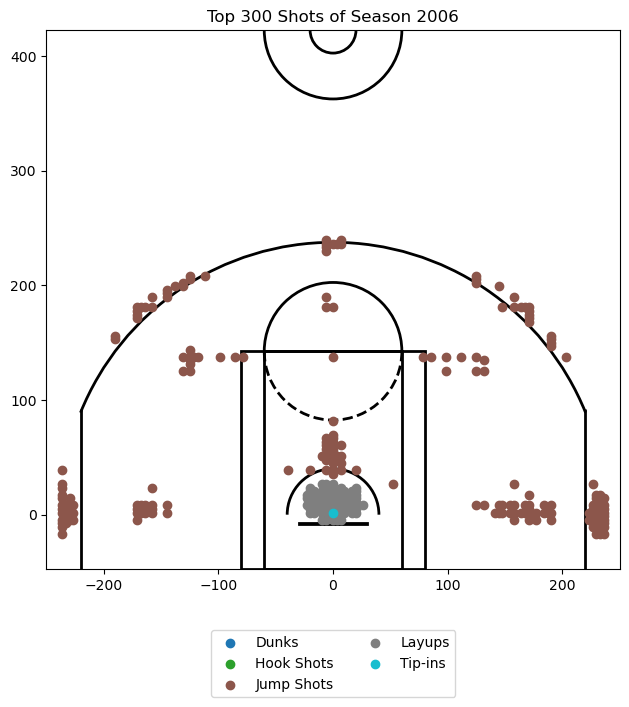

In [15]:
# Define a color map for different action types
colors = plt.cm.get_cmap('tab10', len(top_shots['SHOT_CATEGORY'].unique()))

# Create a figure and a single set of axes
fig, ax = plt.subplots(figsize=(10, 7))

# Draw the court on the main plot
draw_court(ax)

# Plot each group with a different color in the main subplot
handles = []
labels = []
for idx, (action_type, group) in enumerate(top_shots.groupby('SHOT_CATEGORY')):
    color = colors(idx)
    scatter = ax.scatter(group['LOC_X_rounded'] * 10, group['LOC_Y_rounded'] * 9.4 - 47.5, color=color, label=action_type, zorder=2)
    handles.append(scatter)
    labels.append(action_type)

# Set the title
ax.set_title(f"Top 300 Shots of Season {season_1['SEASON_1'].iloc[0]}")

# Create the legend within the same plot
ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

In [16]:
def zone_average(season):
    # Calculate the total number of shots for each BASIC_ZONE
    total_shots = season.groupby("BASIC_ZONE").size()

    # Calculate the percentage of shots made for each BASIC_ZONE
    percentage_shots = season.groupby("BASIC_ZONE")["SHOT_MADE"].mean() * 100

    # Define colors for each zone
    zone_colors = {
        'Restricted Area': 'rgb(55, 83, 109)',
        'In The Paint (Non-RA)': 'rgb(255, 0, 0)',
        'Mid-Range': 'rgb(0, 255, 0)',
        'Left Corner 3': 'rgb(0, 0, 255)',
        'Right Corner 3': 'rgb(255, 255, 0)',
        'Above the Break 3': 'rgb(255, 0, 255)',
        'Backcourt' : 'rgb(0,0,0)'
    }

    # Create the bar plot
    fig = go.Figure()
    for zone, color in zone_colors.items():
        shots_in_zone = season[data_shots["BASIC_ZONE"] == zone]
        fig.add_trace(go.Bar(
            x=[total_shots[zone]],
            y=[percentage_shots[zone]],
            name=zone,
            text=[zone],  # Show BASIC_ZONE as hover text
            hoverinfo='text+y',  # Show BASIC_ZONE and total number of shots as hover information
            marker_color=color
        ))

    # Customize the layout
    fig.update_layout(
        title='Basketball Shot Zone Data',
        xaxis=dict(
            title='Total Number of Shots',
            titlefont_size=16,
            tickfont_size=14,
        ),
        yaxis=dict(
            title='Percentage of Shots Made (%)',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            x=0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        hovermode='closest',  # Show hover information for the nearest data point
        bargap=0,  # gap between bars of adjacent location coordinates
        bargroupgap=0.1  # gap between bars of the same location coordinates
    )

    # Show the plot
    fig.show()

In [17]:
zone_average(data_shots)

In [18]:
def shot_types_average(season):
    # Define colors for each shot category
    category_colors = {
        'Layups': 'rgb(55, 83, 109)',
        'Jump Shots': 'rgb(255, 0, 0)',
        'Dunks': 'rgb(0, 255, 0)',
        'Hook Shots': 'rgb(0, 0, 255)',
        'Tip-ins': 'rgb(255,255,0)',
        'No_Shot': 'rgb(0,0,0)'
        # Add more categories and colors as needed
    }

    # Filter data for the season and calculate shot made percentage per action type
    shots_per_type = season.groupby("SHOT_CATEGORY").size()
    shots_per_type_percentage = season.groupby("SHOT_CATEGORY")["SHOT_MADE"].mean() * 100

    # Create the bar plot
    fig = go.Figure()
    for category, color in category_colors.items():
        if category in shots_per_type.index:
            fig.add_trace(go.Bar(
                x=[shots_per_type[category]],
                y=[shots_per_type_percentage[category]],
                name=category,
                text=f'Shots: {shots_per_type[category]}<br>Percentage: {shots_per_type_percentage[category]:.2f}%',
                hoverinfo='text',  # Show SHOT_CATEGORY, number of shots, and percentage as hover information
                marker_color=color
            ))

    # Customize the layout
    fig.update_layout(
        title='Basketball Shot Type Data',
        xaxis=dict(
            title='Total Number of Shots',
            titlefont_size=16,
            tickfont_size=14,
        ),
        yaxis=dict(
            title='Percentage of Shots Made (%)',
            titlefont_size=16,
            tickfont_size=14,
        ),
        legend=dict(
            x=0,
            y=1.0,
            bgcolor='rgba(255, 255, 255, 0)',
            bordercolor='rgba(255, 255, 255, 0)'
        ),
        bargap=0.15,  # gap between bars of adjacent location coordinates
        bargroupgap=0.1  # gap between bars of the same location coordinates
    )

    # Show the plot
    fig.show()

In [19]:
# Call the function to display the graph
shot_types_average(data_shots)

# **HYPOTHESIS TESTING**

Step 5: Hypothesis Testing for Coefficients
Hypotheses:

**AWAY TEAM vs HOME TEAM shot success**


Hypothesis: There is no significant difference in shooting percentages between home and away games for NBA players.

Null Hypothesis (H0): The mean shooting percentage for home games is equal to the mean shooting percentage for away games.
Alternative Hypothesis (H1): The mean shooting percentage for home games is not equal to the mean shooting percentage for away games.



In [20]:
# Create a dictionary containing the Team ammbreaviations and the corresponding names
team_abbreviations = {
    "ATL": "Atlanta Hawks",
    "BOS": "Boston Celtics",
    "BKN": "Brooklyn Nets",
    "CHA": "Charlotte Hornets",
    "CHI": "Chicago Bulls",
    "CLE": "Cleveland Cavaliers",
    "DAL": "Dallas Mavericks",
    "DEN": "Denver Nuggets",
    "DET": "Detroit Pistons",
    "GSW": "Golden State Warriors",
    "HOU": "Houston Rockets",
    "IND": "Indiana Pacers",
    "LAC": "Los Angeles Clippers",
    "LAL": "Los Angeles Lakers",
    "MEM": "Memphis Grizzlies",
    "MIA": "Miami Heat",
    "MIL": "Milwaukee Bucks",
    "MIN": "Minnesota Timberwolves",
    "NJN": "New Jersey Nets",
    "NOH": "New Orleans Hornets",
    "NOP": "New Orleans Pelicans",
    "NOK": "New Orleans/Oklahoma City Hornets",
    "NYK": "New York Knicks",
    "OKC": "Oklahoma City Thunder",
    "ORL": "Orlando Magic",
    "PHI": "Philadelphia 76ers",
    "PHX": "Phoenix Suns",
    "POR": "Portland Trail Blazers",
    "SAC": "Sacramento Kings",
    "SAS": "San Antonio Spurs",
    "SEA": "Seattle SuperSonics",
    "TOR": "Toronto Raptors",
    "UTA": "Utah Jazz",
    "WAS": "Washington Wizards"
}

team_abbreviations = dict(sorted(team_abbreviations.items()))

In [21]:
def is_home_shot(row):
    return row['TEAM_NAME'] == team_abbreviations[row['HOME_TEAM']]

In [22]:
# Create a new column indicating whether the shot was made by the home team
season_1['IS_HOME_SHOT'] = season_1.apply(is_home_shot, axis=1)

# Divide the values of the shots from Home and Away teams
home_shots = season_1[season_1['IS_HOME_SHOT']]['SHOT_MADE']
away_shots = season_1[~season_1['IS_HOME_SHOT']]['SHOT_MADE']

# Calculate the Mean of the two populations
prop_home = home_shots.mean()
prop_away = away_shots.mean()

# Calculate pooled proportion
pooled_prop = (home_shots.sum() + away_shots.sum() + 0.5) / (len(home_shots) + len(away_shots) + 1)

# Calculate standard error
se = np.sqrt(pooled_prop * (1 - pooled_prop) * (1 / len(home_shots) + 1 / len(away_shots)))

# Calculate z-statistic
z_stat = (prop_home - prop_away) / se

# Two-tailed test, so multiply p-value by 2
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_stat)))

# Print the results
print(f"Z-Statistic: {z_stat}")
print(f"P-Value: {p_value}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in shooting proportions between home and away teams.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in shooting proportions between home and away teams.")

Z-Statistic: 6.209925857917311
P-Value: 5.300959671217242e-10
Reject the null hypothesis. There is a significant difference in shooting proportions between home and away teams.


**Hypotesis: final quarters goal average vs first quarter goal average**

Null Hypothesis (𝐻0​):
There is no difference between the average points scored in the 1st quarter and the last quarter of NBA games.

Alternative Hypothesis (𝐻1):
There is a significant difference between the average points scored in the 1st quarter and the last quarter of NBA games.

In [23]:
# Group by 'GAME_ID' and 'QUARTER', then calculate the mean points for each quarter
season_1 = season_1.groupby(['GAME_ID', 'QUARTER'])['POINTS'].mean().reset_index()

# Filter for the first and last quarters
first_quarter = season_1[season_1['QUARTER'] == 1][['GAME_ID', 'POINTS']]
last_quarter = season_1[season_1['QUARTER'] == 4][['GAME_ID', 'POINTS']]

# Rename columns to distinguish between the two quarters
first_quarter = first_quarter.rename(columns={'POINTS': 'points_first'})
last_quarter = last_quarter.rename(columns={'POINTS': 'points_last'})

In [24]:
# Merge the data on 'GAME_ID' to get pairs of points for each game
merged_data = pd.merge(first_quarter, last_quarter, on='GAME_ID')

# Calculate the differences
merged_data['diff'] = merged_data['points_first'] - merged_data['points_last']

mean_diff = merged_data['points_first'] - merged_data['points_last']

# Calculate the standard deviation of the mean difference
std_diff = mean_diff.std()

# Calculate the standard error of the mean difference
n = len(merged_data)
se_diff = std_diff / (n ** 0.5)

# Calculate the t-statistic
t_stat = mean_diff.mean() / se_diff

# Degrees of freedom
df = n - 1

# Calculate the p-value (two-tailed test)
p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpretation
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the average points scored in the 1st quarter and the last quarter.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the average points scored in the 1st quarter and the last quarter.")

T-statistic: 4.518947420007024
P-value: 6.813627604573824e-06
Reject the null hypothesis: There is a significant difference between the average points scored in the 1st quarter and the last quarter.


**Hypotesis: angle vs center shots**

Null Hypothesis (H0): There is no difference in the shooting success rates between center shots and angle shots.

Alternative Hypothesis (H1): There is a difference in the shooting success rates between center shots and angle shots.


In [25]:
# Divide center and side shots in two Dataframes
season_1 = season_2
center_shots = season_1[((season_1['ANGLE_FROM_CENTER_DEGREES']) > (60)) & ((season_1['ANGLE_FROM_CENTER_DEGREES']) < (120))][['POINTS', 'GAME_ID']]
side_shots = season_1[((season_1['ANGLE_FROM_CENTER_DEGREES']) <= (60))][['POINTS', 'GAME_ID']]
side_shots = pd.concat([side_shots, season_1[((season_1['ANGLE_FROM_CENTER_DEGREES']) >= (120))][['POINTS', 'GAME_ID']]])

# Rename columns
center_shots = center_shots.rename(columns={'POINTS': 'center_points'})
side_shots = side_shots.rename(columns={'POINTS': 'side_points'})

In [26]:
# Merge the data on 'GAME_ID' to get pairs of points for each game
merged_data = pd.merge(center_shots, side_shots, on='GAME_ID')

# Calculate the differences
merged_data['diff'] = merged_data['center_points'] - merged_data['side_points']

# Calculate the t-statistic and the p-value
t_stat, p_value = stats.ttest_rel(merged_data['center_points'], merged_data['side_points'])

# Print the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Interpretation
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference between the average points scored in the 1st quarter and the last quarter.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the average points scored in the 1st quarter and the last quarter.")

T-statistic: 334.18617344235906
P-value: 0.0
Reject the null hypothesis: There is a significant difference between the average points scored in the 1st quarter and the last quarter.


# **LINEAR REGRESSION**



TRY OUT FOR MULTI LINEAR REGRESSION


In [27]:
# LINEAR STANDARD REGRESSION, WITH DISTANCE TO BASKET AS INDEPENDENT VARIABLE
"""
# Define intervals
intervals = [(0, 8), (9, 16), (17, 24), (25, 32), (33, 40), (41, 48), (49,56), (57,64), (65,72), (75,80), (81,88)]

# Use shot distance and points
shot_distance = data_shots['SHOT_DISTANCE'].values
shot_points = data_shots['POINTS'].values

# Calculate the average shot points for each interval
avg_shot_points_list = []
interval_mid_points = []

for interval in intervals:
    start, end = interval
    mask = (shot_distance >= start) & (shot_distance < end)
    avg_shot_points = np.mean(shot_points[mask])
    avg_shot_points_list.append(avg_shot_points)
    interval_mid_points.append((start + end) / 2)

# Calculate the slope (m) and intercept (c) for the linear regression line
n = len(interval_mid_points)
m = (n * np.sum(np.array(interval_mid_points) * np.array(avg_shot_points_list)) - np.sum(interval_mid_points) * np.sum(avg_shot_points_list)) / (n * np.sum(np.array(interval_mid_points)**2) - np.sum(interval_mid_points)**2)
c = (np.sum(avg_shot_points_list) - m * np.sum(interval_mid_points)) / n

# Generate regression line
reg_line = m * np.array(interval_mid_points) + c

# Plot the average points for each interval and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(interval_mid_points, avg_shot_points_list, color='blue', alpha=0.5)
plt.plot(interval_mid_points, reg_line, color='red')
plt.title('Average Points Scored vs Shot Distance')
plt.xlabel('Shot Distance (feet)')
plt.ylabel('Average Points Scored')
plt.grid(True)
plt.show()
"""

"\n# Define intervals\nintervals = [(0, 8), (9, 16), (17, 24), (25, 32), (33, 40), (41, 48), (49,56), (57,64), (65,72), (75,80), (81,88)]\n\n# Use shot distance and points\nshot_distance = data_shots['SHOT_DISTANCE'].values\nshot_points = data_shots['POINTS'].values\n\n# Calculate the average shot points for each interval\navg_shot_points_list = []\ninterval_mid_points = []\n\nfor interval in intervals:\n    start, end = interval\n    mask = (shot_distance >= start) & (shot_distance < end)\n    avg_shot_points = np.mean(shot_points[mask])\n    avg_shot_points_list.append(avg_shot_points)\n    interval_mid_points.append((start + end) / 2)\n\n# Calculate the slope (m) and intercept (c) for the linear regression line\nn = len(interval_mid_points)\nm = (n * np.sum(np.array(interval_mid_points) * np.array(avg_shot_points_list)) - np.sum(interval_mid_points) * np.sum(avg_shot_points_list)) / (n * np.sum(np.array(interval_mid_points)**2) - np.sum(interval_mid_points)**2)\nc = (np.sum(avg_shot

In [28]:
def linear_regression(X, Y):
    """
    Calculates the coefficients of linear regression using the least squares method.

    Arguments:
    X -- List of lists containing the feature values
    Y -- List containing the target variable values

    Returns:
    coefficients -- Tuple containing the coefficients of the linear regression (m, c)
    """
    n_samples = len(X)
    n_features = len(X[0])  # Number of features

    # Step 1: Calculate the means of X and Y
    mean_X = [sum(X) / n_samples for X in zip(*X)]
    mean_Y = sum(Y) / n_samples

    # Step 2: Calculate the deviations and the products of the deviations
    deviations_X = [[X[i][j] - mean_X[j] for j in range(n_features)] for i in range(n_samples)]
    deviations_Y = [Y[i] - mean_Y for i in range(n_samples)]

    # Step 3: Calculate the sums of the products of the deviations
    sum_dev_XY = [sum(deviations_X[i][j] * deviations_Y[i] for i in range(n_samples)) for j in range(n_features)]
    sum_dev_XX = [sum(deviations_X[i][j] * deviations_X[i][j] for i in range(n_samples)) for j in range(n_features)]

    # Step 4: Calculate the coefficients (slopes)
    m = [sum_dev_XY[j] / (sum_dev_XX[j] + 1e-8) if sum_dev_XX[j] != 0 else 0 for j in range(n_features)]

    # Step 5: Calculate the intercept
    c = mean_Y - sum(m[j] * mean_X[j] for j in range(n_features))

    return m, c

In [29]:
def gaussian_elimination(A, b):
    """
    Solve the linear system Ax = b using Gaussian elimination.

    Arguments:
    A -- List of lists containing the coefficient matrix
    b -- List containing the right-hand side

    Returns:
    x -- List containing the solution of the linear system
    """
    n = len(A)
    epsilon = 1e-8  # Regularization constant

    for k in range(n):
        # Find the maximum pivoting element
        max_row = k
        for i in range(k + 1, n):
            if abs(A[i][k]) > abs(A[max_row][k]):
                max_row = i

        # Swap rows
        A[k], A[max_row] = A[max_row], A[k]
        b[k], b[max_row] = b[max_row], b[k]

        # Eliminate elements below the pivot
        for i in range(k + 1, n):
            factor = A[i][k] / (A[k][k] + epsilon)
            for j in range(k, n):
                A[i][j] -= factor * A[k][j]
            b[i] -= factor * b[k]

    # Back substitution
    x = [0] * n
    for k in range(n - 1, -1, -1):
        x[k] = (b[k] - sum(A[k][j] * x[j] for j in range(k + 1, n))) / (A[k][k] + epsilon)

    return x

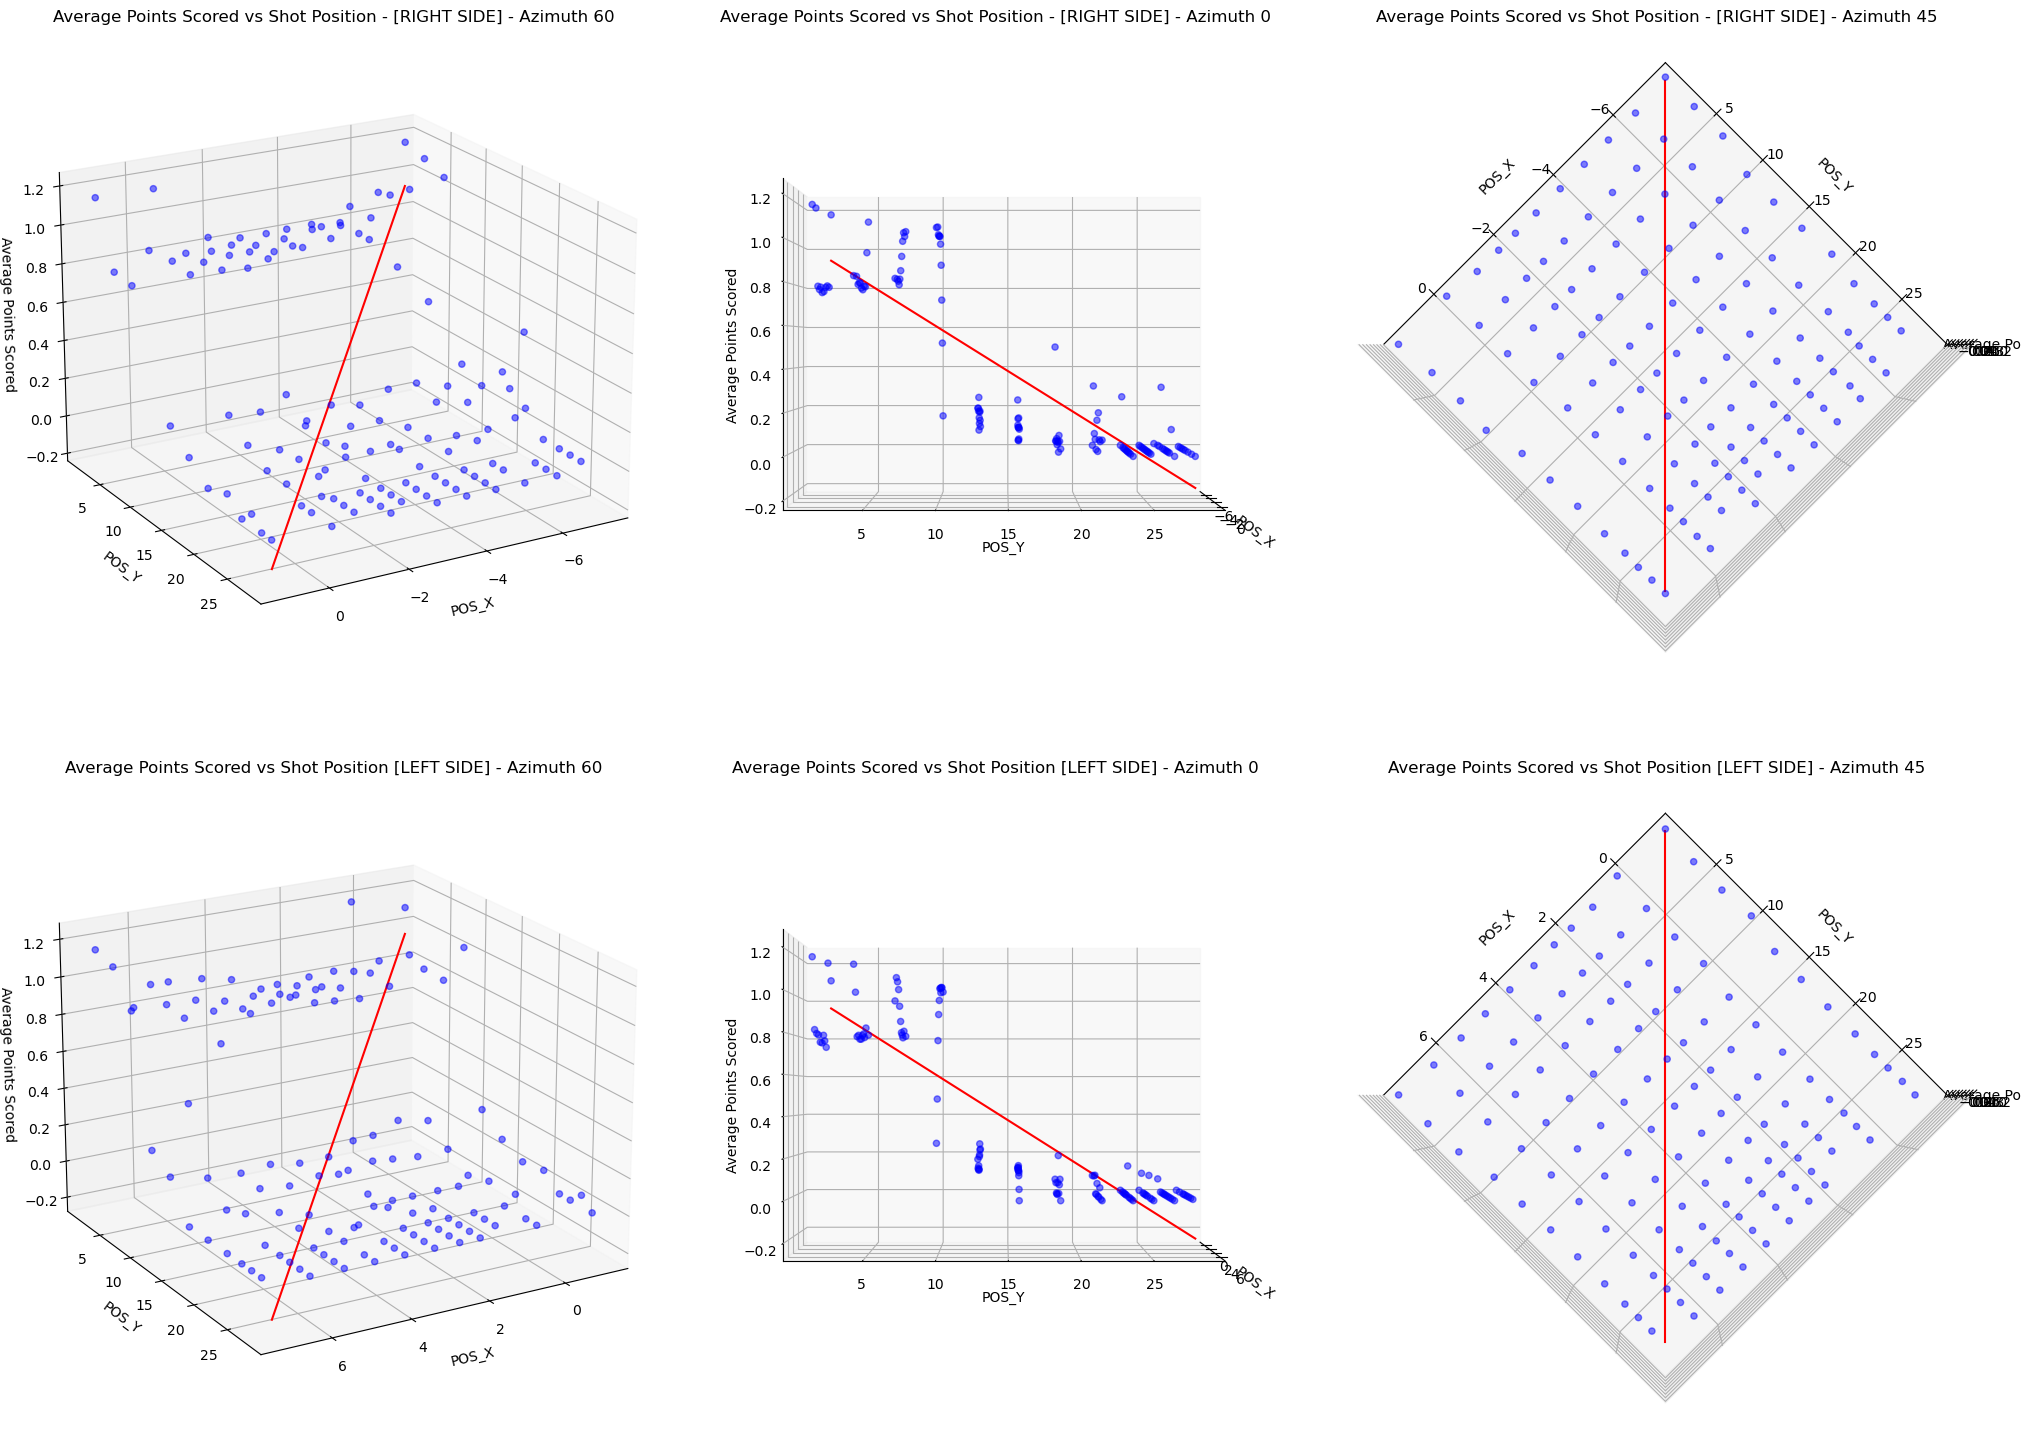

In [30]:
# Define intervals for POS_X for both plots
x_intervals_1 = [(-7.62, -6.678), (-6.678,-5.736), (-5.736, -4.974), (-4.974,-4.212), (-4.212,-3.45), (-3.45, -2.688), (-2.688, -2.156), (-2.156, -1.624), (-1.624, -0.812), (-0.812, 0), (0,0), (0, 2.156)] #meters
x_intervals_2 = [(-2.156,0), (0,0), (0, 0.812), (0.812, 1.624), (1.624, 2.156), (2.156, 2.688), (2.688, 3.45), (3.45, 4.212), (4.212, 4.974), (4.974, 5.736), (5.736, 6.678), (6.678, 7.62)] #meters

# Define intervals for POS_Y for both plots
y_intervals = [(0,0), (0, 2.865), (2.865, 5.73), (5.73, 8.595), (8.595, 11.46), (11.46, 14.325), (14.325, 17.19), (17.19, 20.055), (20.055, 22.92), (22.92, 24.3525), (24.3525, 25.785), (25.785, 27.2175), (27.2175, 28.65)] # meters

# Use POS_X, POS_Y, and POINTS
pos_x = data_shots['LOC_X']
pos_y = data_shots['LOC_Y']
shot_points = data_shots['POINTS']

# Create a figure
fig = plt.figure(figsize=(20, 16))

titles = ['Average Points Scored vs Shot Position - [RIGHT SIDE]', 'Average Points Scored vs Shot Position [LEFT SIDE]']
# Define the azimuth angles for the three points of view
azimuths = [60, 0, 45]
elevations = [20, 0, 90]

for i, x_intervals in enumerate([x_intervals_1, x_intervals_2]):
    avg_shot_points_list = []
    interval_mid_points_x = []
    interval_mid_points_y = []

    for x_interval in x_intervals:
        for y_interval in y_intervals:
            x_start, x_end = x_interval
            y_start, y_end = y_interval

            x_mask = (pos_x >= x_start) & (pos_x < x_end)
            y_mask = (pos_y >= y_start) & (pos_y < y_end)
            mask = x_mask & y_mask

            if np.any(mask):
                avg_shot_points = np.mean(shot_points[mask])
            else:
                avg_shot_points = np.nan  # Handle empty intervals
            avg_shot_points_list.append(avg_shot_points)

            interval_mid_points_x.append((x_start + x_end) / 2)
            interval_mid_points_y.append((y_start + y_end) / 2)

    # Remove nan values from avg_shot_points_list and corresponding mid points
    valid_mask = ~np.isnan(avg_shot_points_list)
    interval_mid_points_x = np.array(interval_mid_points_x)[valid_mask]
    interval_mid_points_y = np.array(interval_mid_points_y)[valid_mask]
    avg_shot_points_list = np.array(avg_shot_points_list)[valid_mask]

    # Perform linear regression from scratch
    X = [[x, y, 1] for x, y in zip(interval_mid_points_x, interval_mid_points_y)]
    Y = avg_shot_points_list.tolist()

    # Solve for coefficients using the normal equation
    coefficients = linear_regression(X, Y)
    m, c = coefficients

    # Generate points for the regression line
    line_x = np.linspace(interval_mid_points_x.min(), interval_mid_points_x.max(), 100)
    line_y = np.linspace(interval_mid_points_y.min(), interval_mid_points_y.max(), 100)
    line_z = m[0] * line_x + m[1] * line_y + c


    # Plot the average points for each interval and the regression line
    for j, (azim, el) in enumerate(zip(azimuths, elevations)):
        ax = fig.add_subplot(2, 3, i * 3 + j + 1, projection='3d')
        ax.scatter(interval_mid_points_x, interval_mid_points_y, avg_shot_points_list, color='blue', alpha=0.5)
        ax.plot(line_x, line_y, line_z, color='red')

        ax.set_title(f'{titles[i]} - Azimuth {azim}')
        ax.set_xlabel('POS_X')
        ax.set_ylabel('POS_Y')
        ax.set_zlabel('Average Points Scored')

        ax.view_init(elev=el, azim=azim)

plt.tight_layout()
plt.show()

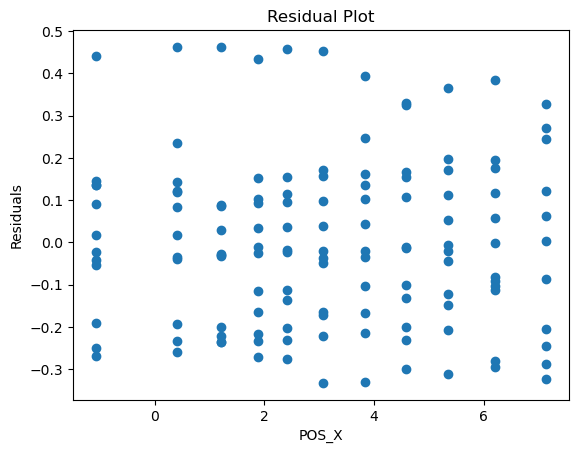

In [31]:
residuals = avg_shot_points_list - (m[0] * interval_mid_points_x + m[1] * interval_mid_points_y + c)
plt.scatter(interval_mid_points_x, residuals)
plt.xlabel('POS_X')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [32]:
from sklearn.metrics import r2_score
r2 = r2_score(avg_shot_points_list, m[0] * interval_mid_points_x + m[1] * interval_mid_points_y + c)
print(f'R-squared: {r2}')

R-squared: 0.7636855859985298


The residuals are randomly scattered around zero, and they don't follow any pattern. Thus the model is valid


R^2 is high enough to tell that 76% of the predicted variables is affected by the independent variable


In [33]:
# Calculate average points for each shot category
total_points_per_category = data_shots.groupby('SHOT_CATEGORY')['POINTS'].sum().to_dict()
count_per_category = data_shots['SHOT_CATEGORY'].value_counts().to_dict()
avg_points_per_category = {category: total_points_per_category[category] / count_per_category[category] for category in total_points_per_category.keys()}

# Calculate average points for each basic zone
total_points_per_zone = data_shots.groupby('BASIC_ZONE')['POINTS'].sum().to_dict()
count_per_zone = data_shots['BASIC_ZONE'].value_counts().to_dict()
avg_points_per_zone = {zone: total_points_per_zone[zone] / count_per_zone[zone] for zone in total_points_per_zone.keys()}

# Calculate average points for each quarter
#total_points_per_quarter = data_shots.groupby('QUARTER')['POINTS'].sum().to_dict()
#count_per_quarter = data_shots['QUARTER'].value_counts().to_dict()
#avg_points_per_quarter = {quarter: total_points_per_quarter[quarter] / count_per_quarter[quarter] for quarter in total_points_per_quarter.keys()}

# Replace one-hot encoding with average points
def encode_shot_category(category):
    return [avg_points_per_category.get(category, 0)]

def encode_basic_zone(zone):
    return [avg_points_per_zone.get(zone, 0)]

#def encode_quarter(quarter):
    #return [avg_points_per_quarter.get(quarter, 0)]

In [34]:
def linear_regression_2(X, Y):
    """
    Calculate the coefficients of linear regression using the least squares method.

    Arguments:
    X -- List of lists containing the feature values
    Y -- List containing the target variable values

    Returns:
    coefficients -- List containing the coefficients of linear regression
    """

    #Convert the list of lists X and the list Y to numpy arrays for easier operations.
    X = np.array(X)
    Y = np.array(Y)

    # Compute the dot product of the transpose of X with X.
    # This results in a square matrix that is the sum of the outer products of the rows of X.
    X_T_X = np.dot(X.T, X)

    # Compute the dot product of the transpose of X with Y.
    # This results in a vector where each element is the sum of the products of the corresponding feature and the target values
    X_T_Y = np.dot(X.T, Y)

    # Solve the linear system of equations X_T_X * coefficients = X_T_Y to find the coefficients.
    # This step uses numpy's linear algebra solver to find the vector of coefficients that minimizes the sum of squared residuals.
    # It uses LU decomposition and forward/backward substitution
    coefficients = np.linalg.solve(X_T_X, X_T_Y)


    return coefficients

MODEL SELECTION:


In [35]:
def calculate_r_squared(X, Y, coefficients):
    # Predict the target values using the coefficients
    y_pred = np.dot(X, coefficients)

    # Calculate the total sum of squares (variance of Y)
    ss_total = np.sum((Y - np.mean(Y))**2)

    # Calculate the residual sum of squares (difference between actual and predicted Y)
    ss_residual = np.sum((Y - y_pred)**2)

    # Calculate R-squared as the proportion of variance explained by the model
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

In [36]:
# Function to calculate Adjusted R-squared
def calculate_adjusted_r_squared(X, Y, coefficients):
    # Number of observations
    n = len(Y)

    # Number of predictors (excluding the intercept term)
    # 'X.shape' returns the dimensions of the array X as a tuple (n_samples, n_features).
    # '[1]' gives the number of columns in X, which corresponds to the number of features.
    # the last column of X is the intercept term (a column of ones) thus I substract 1.

    k = X.shape[1] - 1

    #from the previous func
    r_squared = calculate_r_squared(X, Y, coefficients)


    adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
    return adjusted_r_squared


In [37]:
# Backward Elimination function
def backward_elimination(X, Y, significance_level=0.05):
    """
    OLS estimates the coefficients  by minimizing the sum of the squared residuals (the differences between observed and predicted values).
    Backward elimination to select the most significant features for a linear regression model.

    Arguments:
    X -- 2D numpy array of shape (n_samples, n_features), where each row represents an observation and each column represents a feature.
    Y -- 1D numpy array of shape (n_samples,), containing the target variable values for each observation.

    Returns:
    X -- The dataset with only the remaining significant predictors.
    """

    # Number of variables (features) in the dataset
    num_vars = X.shape[1]

    for i in range(num_vars):
        # Fit the Ordinary Least Squares (OLS) model
        # 'sm.OLS' creates an OLS model object with Y as the dependent variable and X as the independent variables.
        # '.fit()' estimates the coefficients that minimize the sum of squared residuals.
        # basically it just does the same thing of linear_regression_2, but using the methods of the OLS class of statsmodel's api.
        regressor_OLS = sm.OLS(Y, X).fit()

        # Find the maximum p-value among the predictors
        max_p_value = max(regressor_OLS.pvalues).astype(float)

        # If the maximum p-value is greater than the significance level, remove the predictor
        if max_p_value > significance_level:
            for j in range(num_vars - i):
                if regressor_OLS.pvalues[j].astype(float) == max_p_value:
                    # Remove the column (predictor) with the highest p-value (removes the j-th column from the array X)
                    # The '1' indicates that the deletion is along the columns
                    X = np.delete(X, j, 1)

        # Print the summary of the model (like coefficients, p-values, SEs, etc...)
        regressor_OLS.summary()

    # Return the dataset with the remaining predictors
    return X


In [38]:
# Forward Selection function
def forward_selection(X, Y, significance_level=0.05):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    while remaining_features:
        remaining_p_values = []
        for feature in remaining_features:
            selected_features.append(feature)
            X_selected = X[:, selected_features]
            regressor_OLS = sm.OLS(Y, X_selected).fit()
            p_value = regressor_OLS.pvalues[-1]
            remaining_p_values.append(p_value)
            selected_features.pop()
        min_p_value = min(remaining_p_values)
        if min_p_value < significance_level:
            min_p_value_index = remaining_p_values.index(min_p_value)
            selected_features.append(remaining_features[min_p_value_index])
            remaining_features.pop(min_p_value_index)
        else:
            break
    X_selected = X[:, selected_features]
    return X_selected


CONFIDENCE INTERVAL for the multilinear regression

In [39]:
def calculate_confidence_intervals_z(X, Y, coefficients, alpha=0.05):
    """
    Calculate confidence intervals for regression coefficients using the Z-distribution.

    Arguments:
    X -- 2D numpy array of shape (n_samples, n_features), the design matrix of predictor variables.
    Y -- 1D numpy array of shape (n_samples,), the target variable.
    coefficients -- 1D numpy array of shape (n_features,), the estimated coefficients from the regression model.
    alpha -- significance level for the confidence intervals (default is 0.05 for 95% confidence intervals).

    Returns:
    lower_bounds -- 1D numpy array of shape (n_features,), the lower bounds of the confidence intervals.
    upper_bounds -- 1D numpy array of shape (n_features,), the upper bounds of the confidence intervals.
    """

    # Convert X and Y to numpy arrays (if they aren't already)
    X = np.array(X)
    Y = np.array(Y)

    # Calculate predictions using the regression coefficients
    predictions = np.dot(X, coefficients)

    # Calculate residuals (differences between actual and predicted values)
    residuals = Y - predictions

    # Sum of squared residuals
    residual_sum_of_squares = np.sum(residuals**2)

    # Degrees of freedom (number of observations minus the number of predictors)
    degrees_of_freedom = X.shape[0] - X.shape[1]

    # Variance of the residuals (residual sum of squares divided by degrees of freedom)
    residual_variance = residual_sum_of_squares / degrees_of_freedom

    # Calculate the variance-covariance matrix of the coefficients
    # X.T is the transpose of X
    # np.dot(X.T, X) is the matrix product of X transpose and X
    # np.linalg.inv() computes the inverse of the matrix
    XtX_inv = np.linalg.inv(np.dot(X.T, X))

    # The variance of the coefficients is the residual variance multiplied by the inverse of XtX
    coefficient_variance = residual_variance * XtX_inv

    # The standard errors of the coefficients are the square roots of the diagonal elements of the variance-covariance matrix
    standard_errors = np.sqrt(np.diag(coefficient_variance))

    # Calculate the z critical value for the given alpha level (e.g., 1.96 for a 95% confidence interval)
    z_critical = norm.ppf(1 - alpha/2)

    # Calculate the lower and upper bounds of the confidence intervals
    lower_bounds = coefficients - z_critical * standard_errors
    upper_bounds = coefficients + z_critical * standard_errors

    # Return the lower and upper bounds as a tuple
    return lower_bounds, upper_bounds


In [40]:
def calculate_expected_average(x, y, shot_cat, bas_zone, coefficients):
    # Create the feature vector by combining:
    # - x and y coordinates
    # - Encoded shot category
    # - Encoded basic zone
    # - A constant term for the intercept (bias term)

    # Encode the shot category into a feature vector
    shot_cat_features = encode_shot_category(shot_cat)

    # Encode the basic zone into a feature vector
    bas_zone_features = encode_basic_zone(bas_zone)

    # Combine all features into a single list: x, y, encoded shot category, encoded basic zone, and 1 for the intercept
    features = [x, y] + shot_cat_features + bas_zone_features + [1]

    # Calculate the expected average using the linear combination of coefficients and features
    expected_avg = sum(coef * feat for coef, feat in zip(coefficients, features))

    # Ensure the expected average is not negative (xP averages that go on the negative aren't useful for our goal )
    return expected_avg if expected_avg > 0 else 0

"FINAL" MULTILINEAR REGRESSION


Full Model:
POS_X: -0.0035
POS_Y: -0.0402
SHOT_CATEGORY: -0.1906
BASIC_ZONE: 0.3380
INTERCEPT: 0.7994
R^2: 0.39184511404534106
R^2 Adj: 0.3665053271305636

Backward Elimination Model:
POS_X: -0.0404
POS_Y: 0.9649
R^2: 0.381272558063104
R^2 Adj.: 0.3750227859223273

Forward Selection Model:
POS_X: 0.2350
POS_Y: -0.0404
SHOT_CATEGORY: 0.7284
R^2: 0.3876273351839802
R^2 Adj: 0.3751299338612042

Lower bounds of confidence intervals: [-0.03778991 -0.05041614 -0.69164812 -0.19810588  0.24940284]
Upper bounds of confidence intervals: [ 0.03078067 -0.02998709  0.31053795  0.87403126  1.34943978]

Full Model:
POS_X: -0.0140
POS_Y: -0.0451
SHOT_CATEGORY: -0.3466
BASIC_ZONE: 0.1688
INTERCEPT: 1.2449
R^2: 0.6094616867001884
R^2 Adj: 0.5933570139867941

Backward Elimination Model:
POS_X: -0.0432
POS_Y: 1.0032
R^2: 0.5854344359566864
R^2 Adj.: 0.5812887803162532

Forward Selection Model:
POS_X: 1.0032
POS_Y: -0.0432
R^2: 0.5854344359566864
R^2 Adj: 0.5812887803162532

Lower bounds of confidence int

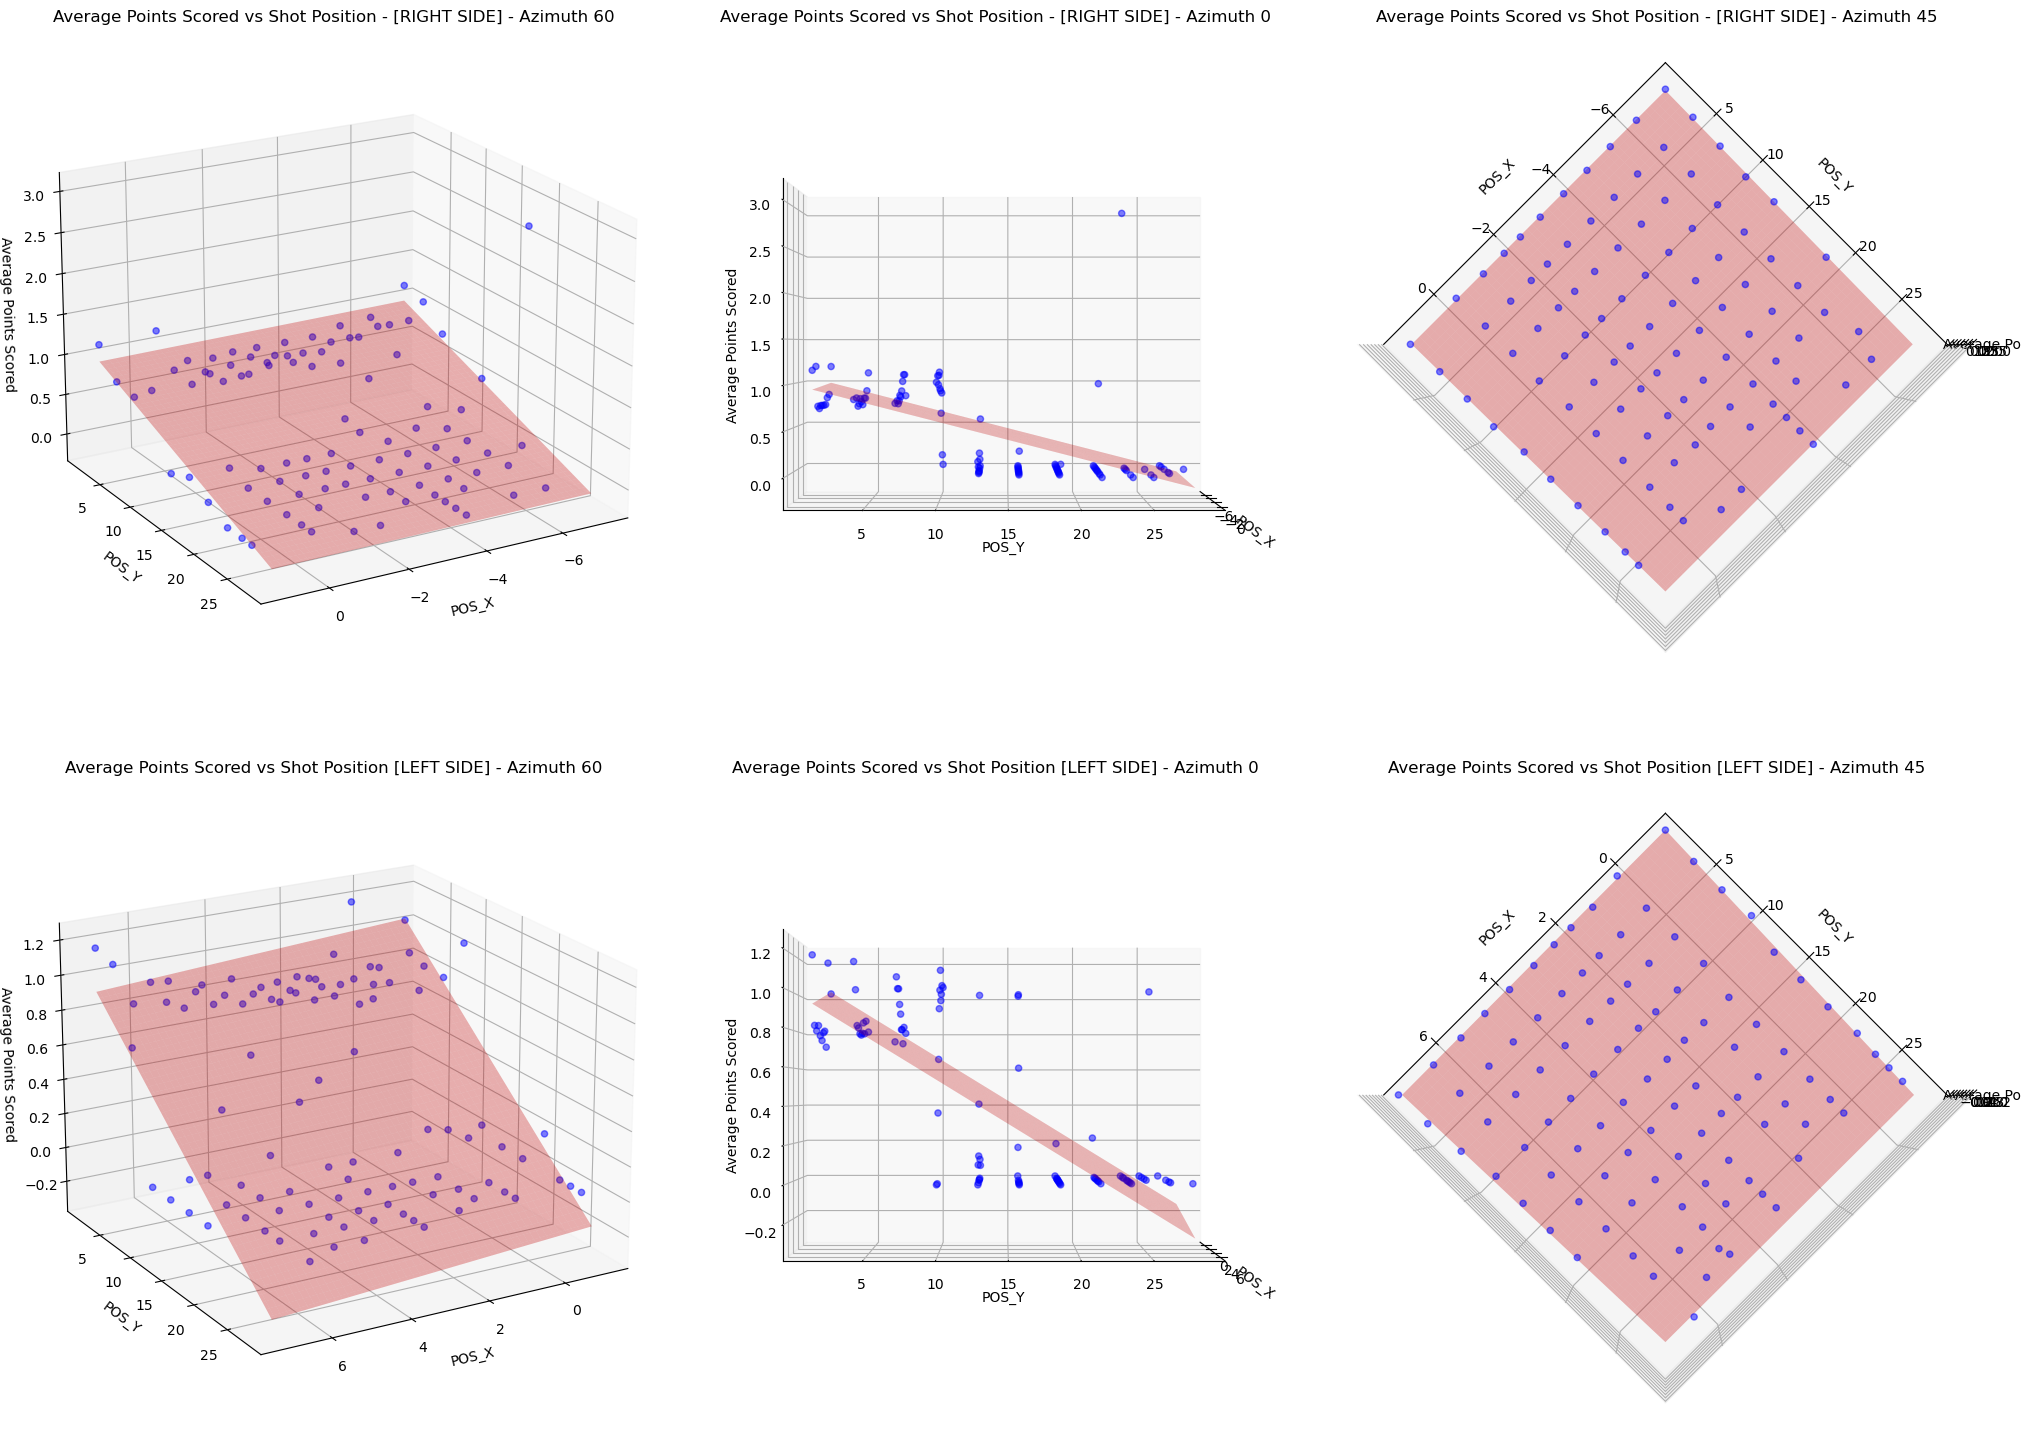

In [41]:
#we're defining intervals for the X and Y positions on the basketball court
#These intervals will help us segment the court into smaller regions for analysis.

#x_i_1 represents the left side of the court in respect to the basket, x_i_2 the right
x_intervals_1 = [(-7.62, -6.678), (-6.678,-5.736), (-5.736, -4.974), (-4.974,-4.212), (-4.212,-3.45), (-3.45, -2.688), (-2.688, -2.156), (-2.156, -1.624), (-1.624, -0.812), (-0.812, 0), (0,0), (0, 2.156)] #meters
x_intervals_2 = [(-2.156,0), (0,0), (0, 0.812), (0.812, 1.624), (1.624, 2.156), (2.156, 2.688), (2.688, 3.45), (3.45, 4.212), (4.212, 4.974), (4.974, 5.736), (5.736, 6.678), (6.678, 7.62)] #meters

#this interval must necessarly be the same dimension as those of x
y_intervals = [(0,0), (0, 2.865), (2.865, 5.73), (5.73, 8.595), (8.595, 11.46), (11.46, 14.325), (14.325, 17.19), (17.19, 20.055), (20.055, 22.92), (22.92, 24.3525), (24.3525, 25.785), (25.785, 27.2175), (27.2175, 28.65)] # meters

# Use POS_X, POS_Y, SHOT_CATEGORY, and POINTS
pos_x = season_1['LOC_X']
pos_y = season_1['LOC_Y']
shot_category = season_1['SHOT_CATEGORY']
basic_zone = season_1['BASIC_ZONE']
shot_points = season_1['POINTS']
#angle_shot = season_1['ANGLE']
#quarter_shot = season_1['QUARTER']

# Create a list of feature names
feature_names = ['POS_X', 'POS_Y', 'SHOT_CATEGORY', 'BASIC_ZONE', 'INTERCEPT']

# Create a figure
fig = plt.figure(figsize=(20, 16))

titles = ['Average Points Scored vs Shot Position - [RIGHT SIDE]', 'Average Points Scored vs Shot Position [LEFT SIDE]']
# Define the azimuth angles for the three points of view
angles = [60, 0, 45]
elevations = [20, 0, 90]

#This is the beginning of a loop where we're iterating over the two sets of X intervals
#We'll generate plots for each set of intervals, representing different regions of the basketball court.
for i, x_intervals in enumerate([x_intervals_1, x_intervals_2]):
    avg_shot_points_list = []
    interval_mid_points_x = []
    interval_mid_points_y = []
    expected_avg_list = []  # Initialize a list to store expected average values

    for x_interval in x_intervals:
        for y_interval in y_intervals:
            #We define the start and end points for the current X and Y intervals and create boolean masks
            #to filter shots falling within these intervals.
            x_start, x_end = x_interval
            y_start, y_end = y_interval

            x_mask = (pos_x >= x_start) & (pos_x < x_end)
            y_mask = (pos_y >= y_start) & (pos_y < y_end)
            mask = x_mask & y_mask

            #We calculate the average points scored for shots falling within the current X and Y intervals
            if np.any(mask):
                avg_shot_points = np.mean(shot_points[mask])
            else:
                avg_shot_points = np.nan  # Handle empty intervals

            #We append the average shot points and the mid-points of the intervals to their respective lists.
            avg_shot_points_list.append(avg_shot_points)
            interval_mid_points_x.append((x_start + x_end) / 2)
            interval_mid_points_y.append((y_start + y_end) / 2)

    #We create a boolean mask to filter out NaN values from avg_shot_points_list
    #and use it to filter interval_mid_points_x and interval_mid_points_y.
    valid_mask = ~np.isnan(avg_shot_points_list)
    interval_mid_points_x = np.array(interval_mid_points_x)[valid_mask]
    interval_mid_points_y = np.array(interval_mid_points_y)[valid_mask]
    avg_shot_points_list = np.array(avg_shot_points_list)[valid_mask]

    # Perform linear regression from scratch
    #We create the feature matrix X for linear regression, including shot posi, one-hot encoded shot categ and court zones, and an intercept term.
    X = [[x, y] + encode_shot_category(shot_cat) + encode_basic_zone(bas_zone) + [1] for x, y, shot_cat, bas_zone in zip(interval_mid_points_x, interval_mid_points_y, shot_category, basic_zone)]
    #We also create the target vector Y from avg_shot_points_list.
    Y = avg_shot_points_list.tolist()

    # Solve for coefficients using the normal equation
    coefficients = linear_regression_2(X, Y)

    r_squared_full = calculate_adjusted_r_squared(np.array(X), Y, coefficients)


    print()


    # Backward Elimination
    X_backward = backward_elimination(np.array(X), np.array(Y))
    coefficients_backward = linear_regression_2(X_backward, Y)

    # Forward Selection
    X_forward = forward_selection(np.array(X), np.array(Y))
    coefficients_forward = linear_regression_2(X_forward, Y)


    # Calculate R-squared and Adjusted R-squared for each model
    r_squared_full = calculate_r_squared(np.array(X), Y, coefficients)
    adj_r_squared_full = calculate_adjusted_r_squared(np.array(X), Y, coefficients)

    r_squared_backward = calculate_r_squared(X_backward, Y, coefficients_backward)
    adj_r_squared_backward = calculate_adjusted_r_squared(X_backward, Y, coefficients_backward)

    r_squared_forward = calculate_r_squared(X_forward, Y, coefficients_forward)
    adj_r_squared_forward = calculate_adjusted_r_squared(X_forward, Y, coefficients_forward)

   # Full model
    print("Full Model:")
    for coef, name in zip(coefficients, feature_names):
        print(f"{name}: {coef:.4f}")
    print(f"R^2: {r_squared_full}")
    print(f"R^2 Adj: {adj_r_squared_full}")


    # Backward elimination model
    print("\nBackward Elimination Model:")
    for coef, name in zip(coefficients_backward, feature_names):
        if coef != 0:
            print(f"{name}: {coef:.4f}")
    print(f"R^2: {r_squared_backward}")
    print(f"R^2 Adj.: {adj_r_squared_backward}")

    # Forward selection model
    print("\nForward Selection Model:")
    for coef, name in zip(coefficients_forward, feature_names):
        if coef != 0:
            print(f"{name}: {coef:.4f}")
    print(f"R^2: {r_squared_forward}")
    print(f"R^2 Adj: {adj_r_squared_forward}")

    lower_bounds, upper_bounds = calculate_confidence_intervals_z(X, Y, coefficients)

    # Print the results
    print()
    print("Lower bounds of confidence intervals:", lower_bounds)
    print("Upper bounds of confidence intervals:", upper_bounds)

    # Number of coefficients
    num_coefficients = len(coefficients)

    #the first two coefficients are for m_x and m_y, the rest for the categorical coeff, and the last one is the constant term
    slopes = coefficients[:-1]
    c = coefficients[-1]

    # We generate points along the X and Y axes to plot the regression plane
    line_x = np.linspace(interval_mid_points_x.min(), interval_mid_points_x.max(), 100)
    line_y = np.linspace(interval_mid_points_y.min(), interval_mid_points_y.max(), 100)

    #We create a grid of points in the X-Y plane and initialize the Z values with zeros.
    grid_x, grid_y = np.meshgrid(line_x, line_y)
    grid_z = np.zeros_like(grid_x)

    #Here, we calculate the Z values for each point in the grid. We iterate over each point in the grid (ix, iy),
    #calculate the features for that point, and then calculate the corresponding Z value using the coefficients
    for ix, x_val in enumerate(line_x):
        for iy, y_val in enumerate(line_y):
            features = [x_val, y_val]  # Initialize features with shot positions
            for zone in basic_zone:
                features += encode_basic_zone(zone)  # Add one-hot encoded representation of each shot category
            for cat in shot_category:
                features += encode_shot_category(cat)
            #for angle in data_shots['ANGLE']:
                #features.append(angle)  # Add ANGLE feature
            #for quarter in data_shots['QUARTER']:
                #features += encode_quarter(quarter)  # Add one-hot encoded QUARTER feature

            grid_z[iy, ix] = sum(slope * feature for slope, feature in zip(slopes, features)) + c

    #We calculate the expected average points scored for each interval by iterating over the mid-points of the intervals
    for x, y, shot_cat, bas_zone in zip(interval_mid_points_x, interval_mid_points_y, shot_category, basic_zone):
        # We calculate the features for each interval
        features = [x, y] + encode_shot_category(shot_cat) + encode_basic_zone(bas_zone) + [1]
        #. and use the obtained coefficients to calculate the expected average points scored.
        expected_avg = sum(coef * feat for coef, feat in zip(coefficients, features))
        expected_avg_list.append(expected_avg)


    # Apply the function to each row in the DataFrame to calculate the expected average for each shot in the dataset.
    # a new column xP_AVG is created to store these values.
    season_1['xP_AVG'] = season_1.apply(lambda row: calculate_expected_average(row['LOC_X'], row['LOC_Y'], row['SHOT_CATEGORY'], row['BASIC_ZONE'], coefficients), axis=1)


    # We iterate over azimuth and elevation angles to create three different views of the 3D plot
    for j, (azim, el) in enumerate(zip(angles, elevations)):
        #or each view, we add a subplot to the figure
        ax = fig.add_subplot(2, 3, i * 3 + j + 1, projection='3d')
        #scatter the average points scored for each interval
        ax.scatter(interval_mid_points_x, interval_mid_points_y, avg_shot_points_list, color='blue', alpha=0.5, label='Actual Average')
        # plot the regression plane
        ax.plot_surface(grid_x, grid_y, grid_z, color='red', alpha=0.3, label='Regression Plane')

        ax.set_title(f'{titles[i]} - Azimuth {azim}')
        ax.set_xlabel('POS_X')
        ax.set_ylabel('POS_Y')
        ax.set_zlabel('Average Points Scored')
        #adjust the viewpoint by using the list I initialised at the beginning
        ax.view_init(elev=el, azim=azim)

plt.tight_layout()
plt.show()

WHAT IF (I USED ANGLE AND QUARTER TOO):

Full Model:
POS_X: -0.0043
POS_Y: -0.0403
ANGLE: 0.0004
SHOT_CATEGORY: -0.1994
BASIC_ZONE: 0.4131
QUARTER: 1.4328
INTERCEPT: -0.7420

Backward Elimination Model:
POS_X: -0.0401
POS_Y: 0.9833

Forward Selection Model:
POS_X: 0.9833
POS_Y: -0.0401

Lower bounds of confidence intervals: [-3.84929150e-02 -5.06124832e-02 -3.14093391e-04 -7.06341800e-01
 -1.35933896e-01 -1.03139264e+00 -3.18075041e+00]
Upper bounds of confidence intervals: [ 2.99134762e-02 -3.00368505e-02  1.10453798e-03  3.07635385e-01
  9.62037985e-01  3.89695579e+00  1.69681026e+00]




Overall Average Expected Points: 0.89
Overall Average Actual Points: 0.98
     Player  Expected Points  Actual Points  Difference
0        15         0.919883       0.934426    0.014543
1        56         0.891526       0.961609    0.070083
2        57         0.902299       0.692308   -0.209991
3        87         0.949389       1.052632    0.103242
4        89         0.870204       0.953353    0.083148
..      ...              ...            ...         ...
450  101230         0.886611       0.520000   -0.366611
451  101236         0.974462       1.123810    0.149348
452  101238         0.906729       0.830189   -0.076541
453  101249         0.866026       0.833333   -0.032693
454  101261         0.875844       0.770270   -0.105574

[455 rows x 4 columns]


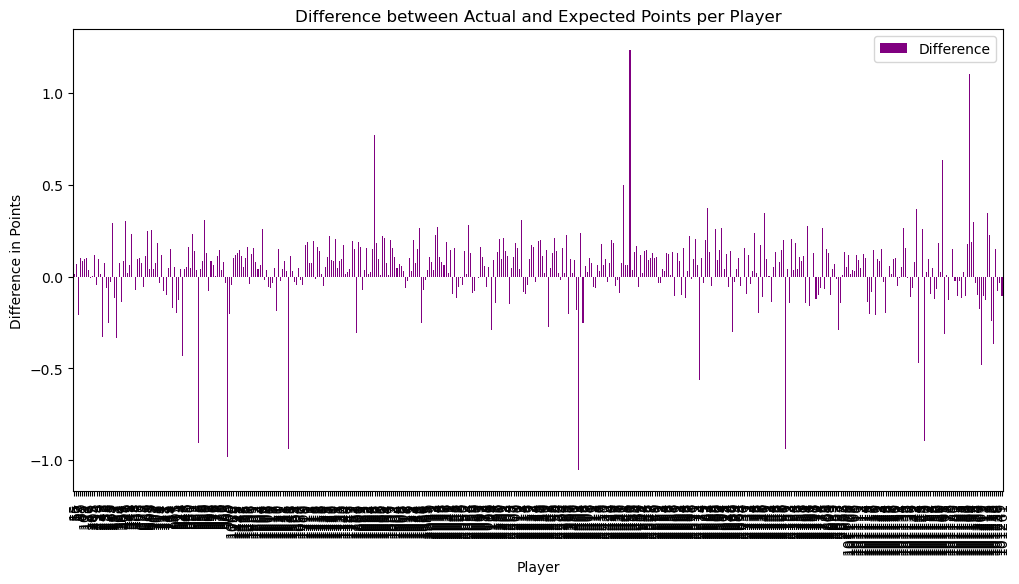

In [42]:

# Calculate overall averages
overall_avg_xp = season_1['xP_AVG'].mean()
overall_avg_actual = season_1['POINTS'].mean()
print(f"Overall Average Expected Points: {overall_avg_xp:.2f}")
print(f"Overall Average Actual Points: {overall_avg_actual:.2f}")

# Calculate averages for each player
player_avg_xp = season_1.groupby('PLAYER_ID')['xP_AVG'].mean()
player_avg_actual = season_1.groupby('PLAYER_ID')['POINTS'].mean()

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Player': player_avg_xp.index,
    'Expected Points': player_avg_xp.values,
    'Actual Points': player_avg_actual.values
})

# Calculate the difference
comparison_df['Difference'] = comparison_df['Actual Points'] - comparison_df['Expected Points']

print(comparison_df)


# Plot the differences
comparison_df.plot(kind='bar', x='Player', y='Difference', figsize=(12, 6), color='purple')
plt.title('Difference between Actual and Expected Points per Player')
plt.xlabel('Player')
plt.ylabel('Difference in Points')
plt.show()


In [43]:
# Divide the shots for year
shots_4_year = len(data_shots.groupby("SEASON_1"))
shots_4_year

years_dict = {}
for i in range(2004, 2024):
  years_dict[i] = (len(data_shots[data_shots["SEASON_1"] == i]))

print(years_dict)

# check
sum_shots = 0
for year in years_dict.values():
  sum_shots += year
print(f"The sum is {sum_shots}")

{2004: 189794, 2005: 197609, 2006: 194303, 2007: 196061, 2008: 200469, 2009: 198992, 2010: 200966, 2011: 199761, 2012: 161205, 2013: 201579, 2014: 204126, 2015: 205548, 2016: 207892, 2017: 209928, 2018: 211653, 2019: 219398, 2020: 188073, 2021: 190945, 2022: 216644, 2023: 217152}
The sum is 4012098


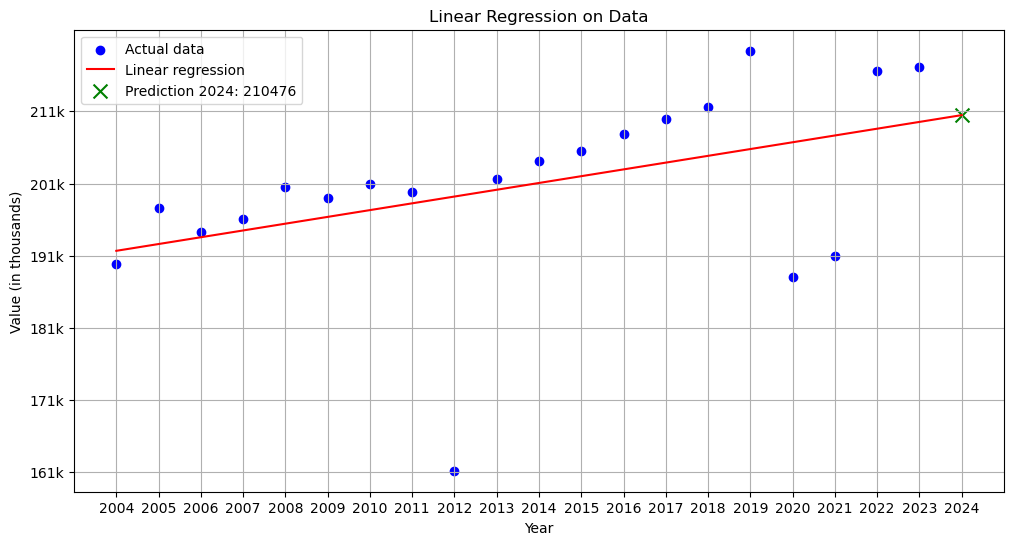

Prediction for 2024: 210475.82
Slope (m): 940.087218045113
Intercept (q): -1692260.713533835


In [44]:
years = np.array(list(years_dict.keys())).reshape(-1,1)
values = np.array(list(years_dict.values()))

# Create linear regression model
model = LinearRegression()

# Train the model
model.fit(years, values)

# Prediction for 2024
pred_2024 = model.predict([[2024]])

# Regression coefficients
m = model.coef_[0]
q = model.intercept_

# Prediction for all years
years_extended = np.arange(2004, 2025).reshape(-1, 1)
values_pred = model.predict(years_extended)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(years, values, color='blue', label='Actual data')
plt.plot(years_extended, values_pred, color='red', label='Linear regression')
plt.scatter([2024], pred_2024, color='green', marker='x', s=100, label=f'Prediction 2024: {pred_2024[0]:.0f}')
plt.xlabel('Year')
plt.ylabel('Value (in thousands)')
plt.title('Linear Regression on Data')
plt.xticks(np.arange(2004, 2025, 1))
plt.yticks(np.arange(min(values) // 1000 * 1000, max(values) // 1000 * 1000 + 1000, 10000),
           labels=[f'{int(x/1000)}k' for x in np.arange(min(values) // 1000 * 1000, max(values) // 1000 * 1000 + 1000, 10000)])
plt.legend()
plt.grid(True)
plt.show()

print("Prediction for 2024:", round(pred_2024[0],2))
print("Slope (m):", m)
print("Intercept (q):", q)

# **Heat Maps**

In [45]:
# creating a list with all the games's id
games_ids = []
games_ids = data_shots["GAME_ID"].unique().tolist()

In [46]:
# Creating a new draw_curt for drawing the field for the heat map, that is smaller than the first
def draw_court2(ax=None, color='black', lw=2, outer_lines=False, interval=20):
    if ax is None:
        ax = plt.gca()

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=feet_to_m(7.5) / 3, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((feet_to_m(-30) / 3, -feet_to_m(7.5) / 3), feet_to_m(60) / 3, -feet_to_m(1) / 3, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((feet_to_m(-80) / 3, -feet_to_m(47.5) / 3), feet_to_m(160) / 3, feet_to_m(190) / 3, linewidth=lw, color=color, fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((feet_to_m(-60) / 3, -feet_to_m(47.5) / 3), feet_to_m(120) / 3, feet_to_m(190) / 3, linewidth=lw, color=color, fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, feet_to_m(142.5) / 3), feet_to_m(120) / 3, feet_to_m(120) / 3, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, feet_to_m(142.5) / 3), feet_to_m(120) / 3, feet_to_m(120) / 3, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), feet_to_m(80) / 3, feet_to_m(80) / 3, theta1=0, theta2=180, linewidth=lw, color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((feet_to_m(-220) / 3, -feet_to_m(47.5) / 3), 0, feet_to_m(140) / 3, linewidth=lw, color=color)
    corner_three_b = Rectangle((feet_to_m(220) / 3, -feet_to_m(47.5) / 3), 0, feet_to_m(140) / 3, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), feet_to_m(475) / 3, feet_to_m(475) / 3, theta1=22, theta2=158, linewidth=lw, color=color)

    # Center Court
    center_outer_arc = Arc((0, feet_to_m(422.5) / 3), feet_to_m(120) / 3, feet_to_m(120) / 3, theta1=180, theta2=0, linewidth=lw, color=color)
    center_inner_arc = Arc((0, feet_to_m(422.5) / 3), feet_to_m(40) / 3, feet_to_m(40) / 3, theta1=180, theta2=0, linewidth=lw, color=color)

    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((feet_to_m(-250) / 3, -feet_to_m(47.5) / 3), feet_to_m(500) / 3, feet_to_m(470) / 3, linewidth=lw, color=color, fill=False)
        court_elements.append(outer_lines)

    for element in court_elements:
        ax.add_patch(element)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(feet_to_m(-250) / 3, feet_to_m(250) / 3)
    ax.set_ylim(-feet_to_m(47.5) / 3, feet_to_m(422.5) / 3)

    return ax

Calculated bandwidth: 3.613540914378692


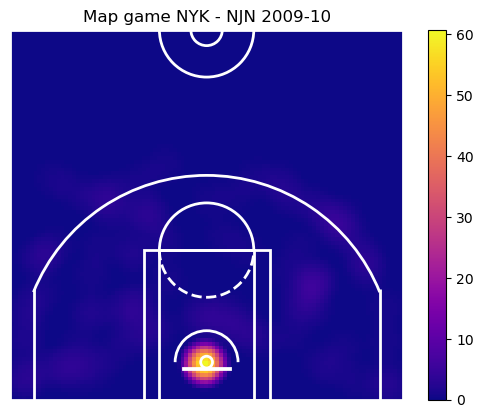

<Figure size 640x480 with 0 Axes>

In [47]:
# Heat map for a random match

from random import choices

game_id =  choices(games_ids)[0]

# Necessary for the intestation of the graph to understand which match we are seeing
shots2 = data_shots2[data_shots2['GAME_ID'] == game_id]
home = shots2['HOME_TEAM'].iloc[0]
away = shots2['AWAY_TEAM'].iloc[0]
season = shots2['SEASON_2'].iloc[0]

# Creations of two parallel list with the coordinates of x and y
coordinates = shots2[["LOC_X", "LOC_Y"]]
x = list(coordinates["LOC_X"].values)
y = list(coordinates["LOC_Y"].values)

#  Each y must be subtracted by 5.2, for fitting properly with the draw of the field
for i in range(len(y)):
  y[i] -= 5.2

# x,y min and max, necessary for draw properly the heat map along all the field
min_x = -24
max_x = 24
min_y = -5
max_y = 45

# Calculating standard deviations and number of points, for calculating the bandwidth (h) of the field
sigma_x = np.std(x)
sigma_y = np.std(y)
n = len(x)

# Silverman's rule of thumb for bandwidth selection
h = 1.06 * min(sigma_x, sigma_y) * n**(-1/6)
print(f"Calculated bandwidth: {h}")

# Lenght of a rectangle of the Heat map
grid_size = 0.5

# Constructing the Mesh Grid
x_grid = np.arange(min_x - h, max_x + h, grid_size)
y_grid = np.arange(min_y - h, max_y + h, grid_size)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Calculating Centre-Points
xc = x_mesh + (grid_size / 2)
yc = y_mesh + (grid_size / 2)


# Define the Quartic Kernel Density Estimator
def kde_quartic(d, h):
  dn = d / h
  S = (15 / 16) * (1 - dn**2) **2
  return S

# Calculate intensity values for each point in the grid
intensity_list = []
for j in range(len(xc)):
  intensity_row = []
  for k in range(len(xc[0])):
    kde_value_list = []
    for i in range(len(x)):
      d = math.sqrt((xc[j][k] - x[i])**2 + (yc[j][k] - y[i])**2)
      if d <= h:
        s = kde_quartic(d, h)
      else:
        s = 0
      kde_value_list.append(s)
    s_total = sum(kde_value_list)
    intensity_row.append(s_total)
  intensity_list.append(intensity_row)

# Converting the list of intensity into an array because it's necessary an array in this function
intensity = np.array(intensity_list)
plt.pcolormesh(x_mesh, y_mesh, intensity, cmap = 'plasma')

# Draw field and title of the graph
draw_court2(plt.gca(), color='white', lw=2, outer_lines=True)
plt.title(f"Map game {home} - {away} {season}")
plt.axis('off')
plt.colorbar()
plt.figure(dpi=100)
plt.show()

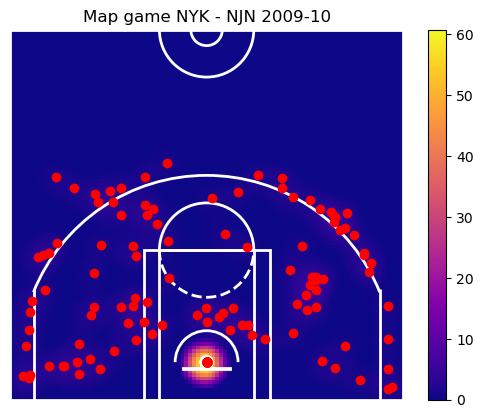

<Figure size 640x480 with 0 Axes>

In [48]:
# This piece of code is for see also the plot of the points on the field for understeand if the heat map do it right
intensity = np.array(intensity_list)
plt.pcolormesh(x_mesh, y_mesh, intensity, cmap = 'plasma')
plt.plot(x, y, 'ro')
draw_court2(plt.gca(), color='white', lw=2, outer_lines=True)
plt.title(f"Map game {home} - {away} {season}")
plt.axis('off')
plt.colorbar()
plt.figure(dpi=100)
plt.show()

Calculated bandwidth h: 1.1693601999628551


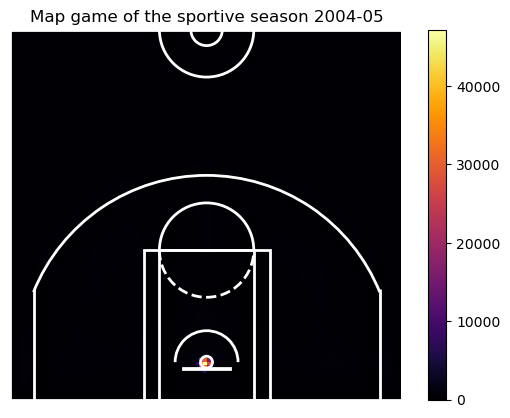

<Figure size 640x480 with 0 Axes>

The % of the different types of shots for the season: 2004-05 are:
Layups: 23.75%
Dunks: 5.07%
Jump Shots: 66.22%
Hook Shots: 2.92%
Bank Shots: 0.00%
Tip-ins: 2.04%
No Shot: 0.00%

As expacted, the most populars are the type of shoot that are closer to the basket, so in the heat map only them are clearly visible


In [49]:
# Heat map of the shots in a season, but with (obvious) bad results

season =  2005

shots2 = data_shots2[data_shots2['SEASON_1'] == season]

sportive_season = shots2['SEASON_2'].iloc[0]

coordinates = shots2[["LOC_X", "LOC_Y"]]
x = list(coordinates["LOC_X"].values)
y = list(coordinates["LOC_Y"].values)

for i in range(len(y)):
  y[i] -= 5.2

min_x = -24
max_x = 24
min_y = -5
max_y = 45

sigma_x = np.std(x)
sigma_y = np.std(y)
n = len(x)

h = 1.06 * min(sigma_x, sigma_y) * n**(-1/6)
print(f"Calculated bandwidth h: {h}")

grid_size = 0.5

x_grid = np.arange(min_x - h, max_x + h, grid_size)
y_grid = np.arange(min_y - h, max_y + h, grid_size)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

xc = x_mesh + (grid_size / 2)
yc = y_mesh + (grid_size / 2)

def kde_quartic(d, h):
  dn = d / h
  S = (15 / 16) * (1 - dn**2) **2
  return S

intensity_list = []
for j in range(len(xc)):
  intensity_row = []
  for k in range(len(xc[0])):
    kde_value_list = []
    for i in range(len(x)):
      d = math.sqrt((xc[j][k] - x[i])**2 + (yc[j][k] - y[i])**2)
      if d <= h:
        s = kde_quartic(d, h)
      else:
        s = 0
      kde_value_list.append(s)
    s_total = sum(kde_value_list)
    intensity_row.append(s_total)
  intensity_list.append(intensity_row)

intensity = np.array(intensity_list)
plt.pcolormesh(x_mesh, y_mesh, intensity, cmap = 'inferno')
draw_court2(plt.gca(), color='white', lw=2, outer_lines=True)
plt.title(f"Map game of the sportive season {sportive_season}")
plt.axis('off')
plt.colorbar()
plt.figure(dpi=100)
plt.show()

p_Layups = ((len(shots2[shots2['SHOT_CATEGORY'] == "Layups"]))/len(shots2))*100
p_Dunks = ((len(shots2[shots2['SHOT_CATEGORY'] == "Dunks"]))/len(shots2)) * 100
p_Jump = ((len(shots2[shots2['SHOT_CATEGORY'] == "Jump Shots"]))/len(shots2)) * 100
p_Hook = ((len(shots2[shots2['SHOT_CATEGORY'] == "Hook Shots"]))/len(shots2)) * 100
p_Bank = ((len(shots2[shots2['SHOT_CATEGORY'] == "Bank Shots"]))/len(shots2)) * 100
p_Tip = ((len(shots2[shots2['SHOT_CATEGORY'] == "Tip-ins"]))/len(shots2)) * 100
p_No = ((len(shots2[shots2['SHOT_CATEGORY'] == "No_Shot"]))/len(shots2)) * 100

print(f"The % of the different types of shots for the season: {sportive_season} are:")
print(f"Layups: {p_Layups:.2f}%")
print(f"Dunks: {p_Dunks:.2f}%")
print(f"Jump Shots: {p_Jump:.2f}%")
print(f"Hook Shots: {p_Hook:.2f}%")
print(f"Bank Shots: {p_Bank:.2f}%")
print(f"Tip-ins: {p_Tip:.2f}%")
print(f"No Shot: {p_No:.2f}%")

print("\nAs expacted, the most populars are the type of shoot that are closer to the basket, so in the heat map only them are clearly visible")